In [1]:
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt
from mnist import MNIST
from utils import show_image
from sklearn import metrics

# 1 - Lendo o dataset

In [2]:
mnist = MNIST('datasets/mnist')
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

shape = (28,28)

# 2 - Criando variaveis de pesos e bias

In [3]:
input_size = shape[0]*shape[1]

layers_size = [
    120,
    80
]

conv_out = [
    20,
    50
]

conv_shape = (5,5)

out_conv_step_size = ((shape[0]/4)**2)*conv_out[-1]


output_size = 10

w = {
    'c1':tf.Variable(tf.random_normal(
        [conv_shape[0],conv_shape[1],1,conv_out[0]])),
    'c2':tf.Variable(tf.random_normal(
        [conv_shape[0],conv_shape[1],conv_out[0],conv_out[1]])),
    'w1':tf.Variable(tf.random_normal(
        [out_conv_step_size, layers_size[0]])),
    'w2':tf.Variable(tf.random_normal([layers_size[0], layers_size[1]])),
    'wo':tf.Variable(tf.random_normal([layers_size[1], output_size])),

}

b = {
    'b1': tf.Variable(tf.random_normal([layers_size[0]])),
    'b2': tf.Variable(tf.random_normal([layers_size[1]])),
    'bo': tf.Variable(tf.random_normal([output_size])),

}

# 3 - Função da Rede

In [4]:
def cnn(input_x):
    reshaped_x = tf.reshape(input_x, shape=[-1,shape[0],shape[1],1])    
    conv1 = tf.nn.conv2d(reshaped_x,w['c1'],strides=[1,1,1,1], padding='SAME')
    act_conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(act_conv1,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    conv2 = tf.nn.conv2d(pool1,w['c2'],strides=[1,1,1,1], padding='SAME')
    act_conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.avg_pool(act_conv2,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    reshaped_x_vecctor = tf.reshape(pool2, shape=[-1,out_conv_step_size])    

    h1 = tf.nn.tanh(tf.add(tf.matmul(reshaped_x_vecctor,w['w1']),b['b1']))
    h2 = tf.nn.tanh(tf.add(tf.matmul(h1,w['w2']),b['b2']))
    
    out = tf.nn.softmax(tf.add(tf.matmul(h2,w['wo']),b['bo']))
    
    return out

# 3.1 - Exemplo

In [6]:
input_x = tf.placeholder(dtype=tf.float32, shape=(2,input_size))
r = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = cnn(input_x)
    r = sess.run(out, feed_dict={input_x: train_images[:2]})
r

array([[5.5576172e-16, 1.3585976e-07, 7.6144097e-08, 3.7969036e-07,
        2.5918957e-06, 3.9751194e-07, 9.9936515e-01, 6.2815740e-04,
        6.0404595e-13, 3.0935316e-06],
       [9.9881348e-05, 4.0298185e-01, 5.1717736e-05, 9.2654000e-04,
        5.3070121e-02, 1.9509603e-06, 1.6049296e-01, 1.9233953e-02,
        3.6314088e-01, 1.4232336e-07]], dtype=float32)

# 4 - Ajustando labels

In [5]:
np_test_images = np.matrix(test_images, dtype=np.float32)

np_train_labels = np.zeros((len(train_labels),10), dtype=np.float32)
for i in range(len(train_labels)):
    np_train_labels[i,train_labels[i]]=1

np_test_labels = np.zeros((len(test_labels),10), dtype=np.int)
for i in range(len(test_labels)):
    np_test_labels[i,test_labels[i]]=1

# 5 - Criando os Placeholders para input e Variáveis auxiliares

In [6]:
n_batchs = 20

total_size = len(train_labels)
batch_size = int(total_size/n_batchs)


init = tf.global_variables_initializer()
train_x = tf.placeholder(shape=(batch_size,input_size),dtype=tf.float32, name='input_x')
train_y = tf.placeholder(shape=(batch_size,output_size),dtype=tf.int32, name='input_y')

test_x = tf.constant(np_test_images,name='test_x')
test_y = tf.constant(test_labels.tolist(), dtype=tf.int64 ,name='test_y')

predict_train = cnn(train_x)
predict_test = tf.math.argmax(cnn(test_x), axis=1)

# 5.1 - Variaveis auxiliares para etapa de otimização

In [21]:
loss_op = tf.losses.mean_squared_error(train_y,predict_train)

adam = tf.train.AdamOptimizer(learning_rate=0.0001)
adam_optimization = adam.minimize(
                loss_op,
                var_list = w.values()+b.values()
            )

In [8]:
loss_vector = []
acc_vector = []

acc_op = tf.contrib.metrics.accuracy(
    predict_test,
    test_y
)

# 5.2 - Saver para salvar o modelo

In [9]:
saver = tf.train.Saver()

In [10]:
tf.test.is_gpu_available()

True

# 5.3 - Função para obter o range do batch

In [12]:
def get_batch_range(batch_i,batch_size,total_size):
    i = batch_size*batch_i
    f = i + batch_size
    if f > total_size:
        f = total_size
    return i,f

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for i in range(2000):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)
        loss_local_vector = []
        for j in range(n_batchs):            
            inicio,fim = get_batch_range(
                j,
                batch_size,
                total_size
            )   
            
            sess.run(adam_optimization, feed_dict={
                train_x:train_images[inicio:fim],
                train_y:np_train_labels[inicio:fim]
            })
            
            l = sess.run(loss_op,
                         feed_dict={
                             train_x:train_images[inicio:fim],
                             train_y:np_train_labels[inicio:fim]})
            
            
            loss_local_vector.append(l)


        acc_value = sess.run(acc_op,
                             feed_dict={
                                 test_x:test_images,
                                 test_y:test_labels})

        acc_vector.append(acc_value)
        loss_vector.append(np.mean(loss_local_vector))

        if(acc_value >= 0.9):
            save_path = saver.save(sess, "model_cnn/model.ckpt")
            print("Model saved in path: %s" % save_path)
            break
            
        
                
        print("LOSS: %s"%(str(l)))
        print("ACC: %s"%(acc_value))
    
    save_path = saver.save(sess, "model_cnn/model.ckpt")
    print("Model saved in path: %s" % save_path)



========== EPOCH 0 ==========
LOSS: 0.15734346
ACC: 0.1076
========== EPOCH 1 ==========
LOSS: 0.15494806
ACC: 0.1153
========== EPOCH 2 ==========
LOSS: 0.15175359
ACC: 0.1217
========== EPOCH 3 ==========
LOSS: 0.1497825
ACC: 0.1364
========== EPOCH 4 ==========
LOSS: 0.14716426
ACC: 0.1452
========== EPOCH 5 ==========
LOSS: 0.1460652
ACC: 0.1523
========== EPOCH 6 ==========
LOSS: 0.14360306
ACC: 0.1581
========== EPOCH 7 ==========
LOSS: 0.14230579
ACC: 0.1728
========== EPOCH 8 ==========
LOSS: 0.13941395
ACC: 0.1798
========== EPOCH 9 ==========
LOSS: 0.1381044
ACC: 0.1862
========== EPOCH 10 ==========
LOSS: 0.1357501
ACC: 0.1955
========== EPOCH 11 ==========
LOSS: 0.13366364
ACC: 0.2004
========== EPOCH 12 ==========
LOSS: 0.13196248
ACC: 0.2175
========== EPOCH 13 ==========
LOSS: 0.12927286
ACC: 0.2249
========== EPOCH 14 ==========
LOSS: 0.12847751
ACC: 0.236
========== EPOCH 15 ==========
LOSS: 0.12605198
ACC: 0.2453
========== EPOCH 16 ==========
LOSS: 0.12477969
ACC: 0.

LOSS: 0.038563404
ACC: 0.7276
========== EPOCH 137 ==========
LOSS: 0.03797378
ACC: 0.7291
========== EPOCH 138 ==========
LOSS: 0.03716823
ACC: 0.7286
========== EPOCH 139 ==========
LOSS: 0.03670875
ACC: 0.7332
========== EPOCH 140 ==========
LOSS: 0.036467463
ACC: 0.735
========== EPOCH 141 ==========
LOSS: 0.035384286
ACC: 0.7369
========== EPOCH 142 ==========
LOSS: 0.03559891
ACC: 0.7335
========== EPOCH 143 ==========
LOSS: 0.035023622
ACC: 0.7368
========== EPOCH 144 ==========
LOSS: 0.034405276
ACC: 0.7357
========== EPOCH 145 ==========
LOSS: 0.03467183
ACC: 0.7372
========== EPOCH 146 ==========
LOSS: 0.03542825
ACC: 0.7385
========== EPOCH 147 ==========
LOSS: 0.034793116
ACC: 0.7418
========== EPOCH 148 ==========
LOSS: 0.034692127
ACC: 0.7413
========== EPOCH 149 ==========
LOSS: 0.034768213
ACC: 0.7436
========== EPOCH 150 ==========
LOSS: 0.03464972
ACC: 0.7448
========== EPOCH 151 ==========
LOSS: 0.034534622
ACC: 0.743
========== EPOCH 152 ==========
LOSS: 0.034317143

LOSS: 0.028422205
ACC: 0.7836
========== EPOCH 271 ==========
LOSS: 0.027690252
ACC: 0.7809
========== EPOCH 272 ==========
LOSS: 0.027254581
ACC: 0.7835
========== EPOCH 273 ==========
LOSS: 0.027081653
ACC: 0.7819
========== EPOCH 274 ==========
LOSS: 0.027546436
ACC: 0.7815
========== EPOCH 275 ==========
LOSS: 0.027452331
ACC: 0.7796
========== EPOCH 276 ==========
LOSS: 0.026411628
ACC: 0.7844
========== EPOCH 277 ==========
LOSS: 0.026446713
ACC: 0.7868
========== EPOCH 278 ==========
LOSS: 0.026410071
ACC: 0.7868
========== EPOCH 279 ==========
LOSS: 0.026464926
ACC: 0.7896
========== EPOCH 280 ==========
LOSS: 0.026853314
ACC: 0.7909
========== EPOCH 281 ==========
LOSS: 0.026436664
ACC: 0.7897
========== EPOCH 282 ==========
LOSS: 0.026713977
ACC: 0.7913
========== EPOCH 283 ==========
LOSS: 0.026443841
ACC: 0.7939
========== EPOCH 284 ==========
LOSS: 0.026089909
ACC: 0.7946
========== EPOCH 285 ==========
LOSS: 0.026294734
ACC: 0.7937
========== EPOCH 286 ==========
LOSS: 0.

LOSS: 0.02456359
ACC: 0.8065
========== EPOCH 404 ==========
LOSS: 0.024741381
ACC: 0.8062
========== EPOCH 405 ==========
LOSS: 0.023818307
ACC: 0.8016
========== EPOCH 406 ==========
LOSS: 0.023961186
ACC: 0.7991
========== EPOCH 407 ==========
LOSS: 0.023338102
ACC: 0.8008
========== EPOCH 408 ==========
LOSS: 0.023328276
ACC: 0.7997
========== EPOCH 409 ==========
LOSS: 0.023769988
ACC: 0.8035
========== EPOCH 410 ==========
LOSS: 0.023969898
ACC: 0.8038
========== EPOCH 411 ==========
LOSS: 0.024821654
ACC: 0.8038
========== EPOCH 412 ==========
LOSS: 0.024598153
ACC: 0.8034
========== EPOCH 413 ==========
LOSS: 0.024797022
ACC: 0.8031
========== EPOCH 414 ==========
LOSS: 0.024461035
ACC: 0.8041
========== EPOCH 415 ==========
LOSS: 0.02467026
ACC: 0.8038
========== EPOCH 416 ==========
LOSS: 0.025249038
ACC: 0.8041
========== EPOCH 417 ==========
LOSS: 0.02535859
ACC: 0.8041
========== EPOCH 418 ==========
LOSS: 0.025148816
ACC: 0.8064
========== EPOCH 419 ==========
LOSS: 0.024

LOSS: 0.02267218
ACC: 0.8296
========== EPOCH 537 ==========
LOSS: 0.022382688
ACC: 0.8283
========== EPOCH 538 ==========
LOSS: 0.022983069
ACC: 0.8268
========== EPOCH 539 ==========
LOSS: 0.023642689
ACC: 0.8257
========== EPOCH 540 ==========
LOSS: 0.023183668
ACC: 0.827
========== EPOCH 541 ==========
LOSS: 0.022726575
ACC: 0.827
========== EPOCH 542 ==========
LOSS: 0.022856453
ACC: 0.8263
========== EPOCH 543 ==========
LOSS: 0.022409001
ACC: 0.8286
========== EPOCH 544 ==========
LOSS: 0.023360832
ACC: 0.8263
========== EPOCH 545 ==========
LOSS: 0.023015324
ACC: 0.8263
========== EPOCH 546 ==========
LOSS: 0.023694333
ACC: 0.8259
========== EPOCH 547 ==========
LOSS: 0.022963306
ACC: 0.8264
========== EPOCH 548 ==========
LOSS: 0.022678414
ACC: 0.8271
========== EPOCH 549 ==========
LOSS: 0.022595314
ACC: 0.8275
========== EPOCH 550 ==========
LOSS: 0.022254953
ACC: 0.8288
========== EPOCH 551 ==========
LOSS: 0.022202743
ACC: 0.8297
========== EPOCH 552 ==========
LOSS: 0.022

LOSS: 0.020615993
ACC: 0.8357
========== EPOCH 670 ==========
LOSS: 0.02092231
ACC: 0.8369
========== EPOCH 671 ==========
LOSS: 0.020881897
ACC: 0.8355
========== EPOCH 672 ==========
LOSS: 0.020712776
ACC: 0.8326
========== EPOCH 673 ==========
LOSS: 0.020757992
ACC: 0.8324
========== EPOCH 674 ==========
LOSS: 0.020982733
ACC: 0.832
========== EPOCH 675 ==========
LOSS: 0.020877922
ACC: 0.8331
========== EPOCH 676 ==========
LOSS: 0.02050142
ACC: 0.8328
========== EPOCH 677 ==========
LOSS: 0.020500679
ACC: 0.8347
========== EPOCH 678 ==========
LOSS: 0.020431343
ACC: 0.8346
========== EPOCH 679 ==========
LOSS: 0.020406092
ACC: 0.8347
========== EPOCH 680 ==========
LOSS: 0.020502241
ACC: 0.8336
========== EPOCH 681 ==========
LOSS: 0.020435208
ACC: 0.8334
========== EPOCH 682 ==========
LOSS: 0.020426163
ACC: 0.8345
========== EPOCH 683 ==========
LOSS: 0.020426188
ACC: 0.8332
========== EPOCH 684 ==========
LOSS: 0.020289503
ACC: 0.8335
========== EPOCH 685 ==========
LOSS: 0.020

LOSS: 0.017498735
ACC: 0.8457
========== EPOCH 803 ==========
LOSS: 0.017585311
ACC: 0.8474
========== EPOCH 804 ==========
LOSS: 0.01764868
ACC: 0.8456
========== EPOCH 805 ==========
LOSS: 0.017608488
ACC: 0.8448
========== EPOCH 806 ==========
LOSS: 0.017207693
ACC: 0.8474
========== EPOCH 807 ==========
LOSS: 0.016817722
ACC: 0.8464
========== EPOCH 808 ==========
LOSS: 0.016897852
ACC: 0.8479
========== EPOCH 809 ==========
LOSS: 0.016735543
ACC: 0.8471
========== EPOCH 810 ==========
LOSS: 0.016721819
ACC: 0.8479
========== EPOCH 811 ==========
LOSS: 0.01686226
ACC: 0.8498
========== EPOCH 812 ==========
LOSS: 0.01740393
ACC: 0.8488
========== EPOCH 813 ==========
LOSS: 0.017197518
ACC: 0.8495
========== EPOCH 814 ==========
LOSS: 0.016555505
ACC: 0.8512
========== EPOCH 815 ==========
LOSS: 0.016401721
ACC: 0.8509
========== EPOCH 816 ==========
LOSS: 0.016665652
ACC: 0.8497
========== EPOCH 817 ==========
LOSS: 0.016610242
ACC: 0.8498
========== EPOCH 818 ==========
LOSS: 0.016

LOSS: 0.017643895
ACC: 0.8576
========== EPOCH 936 ==========
LOSS: 0.017123299
ACC: 0.8568
========== EPOCH 937 ==========
LOSS: 0.017443998
ACC: 0.8592
========== EPOCH 938 ==========
LOSS: 0.017192403
ACC: 0.8567
========== EPOCH 939 ==========
LOSS: 0.016993795
ACC: 0.8538
========== EPOCH 940 ==========
LOSS: 0.017164722
ACC: 0.856
========== EPOCH 941 ==========
LOSS: 0.017133977
ACC: 0.8562
========== EPOCH 942 ==========
LOSS: 0.01704759
ACC: 0.8527
========== EPOCH 943 ==========
LOSS: 0.017877705
ACC: 0.8571
========== EPOCH 944 ==========
LOSS: 0.017247738
ACC: 0.8562
========== EPOCH 945 ==========
LOSS: 0.017504396
ACC: 0.8578
========== EPOCH 946 ==========
LOSS: 0.017462602
ACC: 0.857
========== EPOCH 947 ==========
LOSS: 0.017807543
ACC: 0.8583
========== EPOCH 948 ==========
LOSS: 0.017262686
ACC: 0.8551
========== EPOCH 949 ==========
LOSS: 0.016916076
ACC: 0.854
========== EPOCH 950 ==========
LOSS: 0.017320154
ACC: 0.8543
========== EPOCH 951 ==========
LOSS: 0.0173

LOSS: 0.01709603
ACC: 0.8516
========== EPOCH 1068 ==========
LOSS: 0.016811673
ACC: 0.8541
========== EPOCH 1069 ==========
LOSS: 0.016580096
ACC: 0.8561
========== EPOCH 1070 ==========
LOSS: 0.016840588
ACC: 0.8565
========== EPOCH 1071 ==========
LOSS: 0.017069604
ACC: 0.856
========== EPOCH 1072 ==========
LOSS: 0.017424028
ACC: 0.8507
========== EPOCH 1073 ==========
LOSS: 0.017821267
ACC: 0.8518
========== EPOCH 1074 ==========
LOSS: 0.017924933
ACC: 0.8531
========== EPOCH 1075 ==========
LOSS: 0.017509395
ACC: 0.8558
========== EPOCH 1076 ==========
LOSS: 0.017601859
ACC: 0.8532
========== EPOCH 1077 ==========
LOSS: 0.017665522
ACC: 0.8514
========== EPOCH 1078 ==========
LOSS: 0.017951762
ACC: 0.8534
========== EPOCH 1079 ==========
LOSS: 0.018274471
ACC: 0.8532
========== EPOCH 1080 ==========
LOSS: 0.017436652
ACC: 0.8514
========== EPOCH 1081 ==========
LOSS: 0.01729635
ACC: 0.8531
========== EPOCH 1082 ==========
LOSS: 0.01686936
ACC: 0.8508
========== EPOCH 1083 =======

LOSS: 0.017790247
ACC: 0.8551
========== EPOCH 1199 ==========
LOSS: 0.017865429
ACC: 0.8555
========== EPOCH 1200 ==========
LOSS: 0.017598633
ACC: 0.857
========== EPOCH 1201 ==========
LOSS: 0.018132772
ACC: 0.8555
========== EPOCH 1202 ==========
LOSS: 0.018155178
ACC: 0.8559
========== EPOCH 1203 ==========
LOSS: 0.017672047
ACC: 0.8576
========== EPOCH 1204 ==========
LOSS: 0.017556507
ACC: 0.8583
========== EPOCH 1205 ==========
LOSS: 0.017602634
ACC: 0.8599
========== EPOCH 1206 ==========
LOSS: 0.017330172
ACC: 0.8615
========== EPOCH 1207 ==========
LOSS: 0.017305978
ACC: 0.8594
========== EPOCH 1208 ==========
LOSS: 0.017509455
ACC: 0.8603
========== EPOCH 1209 ==========
LOSS: 0.017128473
ACC: 0.8603
========== EPOCH 1210 ==========
LOSS: 0.017508578
ACC: 0.8608
========== EPOCH 1211 ==========
LOSS: 0.01775565
ACC: 0.8622
========== EPOCH 1212 ==========
LOSS: 0.017836742
ACC: 0.862
========== EPOCH 1213 ==========
LOSS: 0.017754346
ACC: 0.8606
========== EPOCH 1214 ======

LOSS: 0.017199378
ACC: 0.8582
========== EPOCH 1330 ==========
LOSS: 0.016749162
ACC: 0.8583
========== EPOCH 1331 ==========
LOSS: 0.016518727
ACC: 0.8552
========== EPOCH 1332 ==========
LOSS: 0.016332556
ACC: 0.8554
========== EPOCH 1333 ==========
LOSS: 0.016446201
ACC: 0.8579
========== EPOCH 1334 ==========
LOSS: 0.016422184
ACC: 0.8582
========== EPOCH 1335 ==========
LOSS: 0.01691742
ACC: 0.8553
========== EPOCH 1336 ==========
LOSS: 0.016581466
ACC: 0.8562
========== EPOCH 1337 ==========
LOSS: 0.01670097
ACC: 0.8549
========== EPOCH 1338 ==========
LOSS: 0.016478848
ACC: 0.8555
========== EPOCH 1339 ==========
LOSS: 0.016225742
ACC: 0.8579
========== EPOCH 1340 ==========
LOSS: 0.016036488
ACC: 0.8586
========== EPOCH 1341 ==========
LOSS: 0.01571927
ACC: 0.8572
========== EPOCH 1342 ==========
LOSS: 0.016097335
ACC: 0.856
========== EPOCH 1343 ==========
LOSS: 0.01593368
ACC: 0.8574
========== EPOCH 1344 ==========
LOSS: 0.016285751
ACC: 0.8571
========== EPOCH 1345 ========

LOSS: 0.016996672
ACC: 0.8571
========== EPOCH 1461 ==========
LOSS: 0.017167713
ACC: 0.8585
========== EPOCH 1462 ==========
LOSS: 0.017035663
ACC: 0.8578
========== EPOCH 1463 ==========
LOSS: 0.017141938
ACC: 0.8541
========== EPOCH 1464 ==========
LOSS: 0.017101193
ACC: 0.8538
========== EPOCH 1465 ==========
LOSS: 0.016989542
ACC: 0.8536
========== EPOCH 1466 ==========
LOSS: 0.01699178
ACC: 0.8557
========== EPOCH 1467 ==========
LOSS: 0.016682373
ACC: 0.8535
========== EPOCH 1468 ==========
LOSS: 0.016622292
ACC: 0.8552
========== EPOCH 1469 ==========
LOSS: 0.016938219
ACC: 0.8568
========== EPOCH 1470 ==========
LOSS: 0.017197179
ACC: 0.8587
========== EPOCH 1471 ==========
LOSS: 0.017378429
ACC: 0.8553
========== EPOCH 1472 ==========
LOSS: 0.017228574
ACC: 0.8544
========== EPOCH 1473 ==========
LOSS: 0.016918974
ACC: 0.8549
========== EPOCH 1474 ==========
LOSS: 0.016631298
ACC: 0.8544
========== EPOCH 1475 ==========
LOSS: 0.01677423
ACC: 0.8564
========== EPOCH 1476 =====

LOSS: 0.016559398
ACC: 0.8612
========== EPOCH 1592 ==========
LOSS: 0.016564287
ACC: 0.8623
========== EPOCH 1593 ==========
LOSS: 0.01709589
ACC: 0.8616
========== EPOCH 1594 ==========
LOSS: 0.01696887
ACC: 0.8632
========== EPOCH 1595 ==========
LOSS: 0.016693588
ACC: 0.8622
========== EPOCH 1596 ==========
LOSS: 0.016512591
ACC: 0.8609
========== EPOCH 1597 ==========
LOSS: 0.016452448
ACC: 0.8616
========== EPOCH 1598 ==========
LOSS: 0.016556067
ACC: 0.8619
========== EPOCH 1599 ==========
LOSS: 0.0166334
ACC: 0.8627
========== EPOCH 1600 ==========
LOSS: 0.016678145
ACC: 0.8637
========== EPOCH 1601 ==========
LOSS: 0.0165085
ACC: 0.8643
========== EPOCH 1602 ==========
LOSS: 0.0169541
ACC: 0.8647
========== EPOCH 1603 ==========
LOSS: 0.016866896
ACC: 0.8637
========== EPOCH 1604 ==========
LOSS: 0.016710034
ACC: 0.8652
========== EPOCH 1605 ==========
LOSS: 0.01665781
ACC: 0.8668
========== EPOCH 1606 ==========
LOSS: 0.016818631
ACC: 0.8669
========== EPOCH 1607 ==========
L

LOSS: 0.014789117
ACC: 0.8668
========== EPOCH 1723 ==========
LOSS: 0.015102693
ACC: 0.8675
========== EPOCH 1724 ==========
LOSS: 0.01582514
ACC: 0.8686
========== EPOCH 1725 ==========
LOSS: 0.015225105
ACC: 0.8716
========== EPOCH 1726 ==========
LOSS: 0.015020987
ACC: 0.8709
========== EPOCH 1727 ==========
LOSS: 0.014833767
ACC: 0.8733
========== EPOCH 1728 ==========
LOSS: 0.014866499
ACC: 0.8724
========== EPOCH 1729 ==========
LOSS: 0.014712534
ACC: 0.8716
========== EPOCH 1730 ==========
LOSS: 0.014834158
ACC: 0.8731
========== EPOCH 1731 ==========
LOSS: 0.014929621
ACC: 0.8733
========== EPOCH 1732 ==========
LOSS: 0.014664166
ACC: 0.8708
========== EPOCH 1733 ==========
LOSS: 0.014862943
ACC: 0.873
========== EPOCH 1734 ==========
LOSS: 0.014900538
ACC: 0.8729
========== EPOCH 1735 ==========
LOSS: 0.014636411
ACC: 0.8727
========== EPOCH 1736 ==========
LOSS: 0.014840715
ACC: 0.8704
========== EPOCH 1737 ==========
LOSS: 0.014839607
ACC: 0.8717
========== EPOCH 1738 =====

LOSS: 0.01512301
ACC: 0.8757
========== EPOCH 1854 ==========
LOSS: 0.015220398
ACC: 0.8765
========== EPOCH 1855 ==========
LOSS: 0.015241168
ACC: 0.8782
========== EPOCH 1856 ==========
LOSS: 0.015455148
ACC: 0.875
========== EPOCH 1857 ==========
LOSS: 0.015720407
ACC: 0.8737
========== EPOCH 1858 ==========
LOSS: 0.015737671
ACC: 0.8712
========== EPOCH 1859 ==========
LOSS: 0.0154355485
ACC: 0.8722
========== EPOCH 1860 ==========
LOSS: 0.015378501
ACC: 0.8718
========== EPOCH 1861 ==========
LOSS: 0.015050353
ACC: 0.8722
========== EPOCH 1862 ==========
LOSS: 0.0151161095
ACC: 0.8722
========== EPOCH 1863 ==========
LOSS: 0.015383434
ACC: 0.8726
========== EPOCH 1864 ==========
LOSS: 0.015331637
ACC: 0.8743
========== EPOCH 1865 ==========
LOSS: 0.015391427
ACC: 0.8741
========== EPOCH 1866 ==========
LOSS: 0.015188365
ACC: 0.876
========== EPOCH 1867 ==========
LOSS: 0.015537968
ACC: 0.8735
========== EPOCH 1868 ==========
LOSS: 0.015401479
ACC: 0.8741
========== EPOCH 1869 ====

LOSS: 0.013906457
ACC: 0.8806
========== EPOCH 1985 ==========
LOSS: 0.0141994795
ACC: 0.8803
========== EPOCH 1986 ==========
LOSS: 0.014332868
ACC: 0.8823
========== EPOCH 1987 ==========
LOSS: 0.014312751
ACC: 0.8816
========== EPOCH 1988 ==========
LOSS: 0.014210036
ACC: 0.8833
========== EPOCH 1989 ==========
LOSS: 0.014053255
ACC: 0.8826
========== EPOCH 1990 ==========
LOSS: 0.014194036
ACC: 0.8801
========== EPOCH 1991 ==========
LOSS: 0.014372906
ACC: 0.8803
========== EPOCH 1992 ==========
LOSS: 0.013993307
ACC: 0.8815
========== EPOCH 1993 ==========
LOSS: 0.0140076615
ACC: 0.8838
========== EPOCH 1994 ==========
LOSS: 0.013818714
ACC: 0.8844
========== EPOCH 1995 ==========
LOSS: 0.013632841
ACC: 0.8823
========== EPOCH 1996 ==========
LOSS: 0.0138447145
ACC: 0.8805
========== EPOCH 1997 ==========
LOSS: 0.0138478195
ACC: 0.8832
========== EPOCH 1998 ==========
LOSS: 0.014100332
ACC: 0.8834
========== EPOCH 1999 ==========
LOSS: 0.014588654
ACC: 0.8824
Model saved in path: 

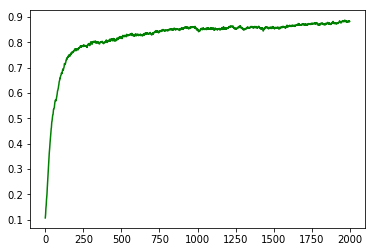

In [14]:
plt.plot(acc_vector, 'g-')
plt.show()

In [17]:
results_formated = []

with tf.Session() as sess:
    saver.restore(sess, "model_cnn/model.ckpt")
    results_formated = sess.run(predict_test,
                             feed_dict={
                                 test_x:test_images})
    

    print("Model restored.")
    print("COMPARE:")
    print("PREDICT: %s"%results_formated[:15])
    print("READ:    %s"%test_labels[:15].tolist())
    

INFO:tensorflow:Restoring parameters from model_cnn/model.ckpt
Model restored.
COMPARE:
PREDICT: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1]
READ:    [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1]


In [18]:
metrics.classification.accuracy_score(test_labels.tolist(),results_formated)

0.8824

# Continuar treinando

In [22]:


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    saver.restore(sess, "model_cnn/model.ckpt")
    for i in range(2000):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)
        loss_local_vector = []
        for j in range(n_batchs):            
            inicio,fim = get_batch_range(
                j,
                batch_size,
                total_size
            )   
            
            sess.run(adam_optimization, feed_dict={
                train_x:train_images[inicio:fim],
                train_y:np_train_labels[inicio:fim]
            })
            
            l = sess.run(loss_op,
                         feed_dict={
                             train_x:train_images[inicio:fim],
                             train_y:np_train_labels[inicio:fim]})
            
            
            loss_local_vector.append(l)


        acc_value = sess.run(acc_op,
                             feed_dict={
                                 test_x:test_images,
                                 test_y:test_labels})

        acc_vector.append(acc_value)
        loss_vector.append(np.mean(loss_local_vector))

        if(acc_value >= 0.9):
            save_path = saver.save(sess, "model_cnn/model.ckpt")
            print("Model saved in path: %s" % save_path)
            break
            
        
                
        print("LOSS: %s"%(str(l)))
        print("ACC: %s"%(acc_value))
    
    save_path = saver.save(sess, "model_cnn/model.ckpt")
    print("Model saved in path: %s" % save_path)

INFO:tensorflow:Restoring parameters from model_cnn/model.ckpt
========== EPOCH 0 ==========
LOSS: 0.014750309
ACC: 0.8828
========== EPOCH 1 ==========
LOSS: 0.014752723
ACC: 0.8841
========== EPOCH 2 ==========
LOSS: 0.014838962
ACC: 0.8821
========== EPOCH 3 ==========
LOSS: 0.014708185
ACC: 0.8832
========== EPOCH 4 ==========
LOSS: 0.014632561
ACC: 0.8814
========== EPOCH 5 ==========
LOSS: 0.014464114
ACC: 0.8826
========== EPOCH 6 ==========
LOSS: 0.014371349
ACC: 0.8834
========== EPOCH 7 ==========
LOSS: 0.014353368
ACC: 0.8838
========== EPOCH 8 ==========
LOSS: 0.014346934
ACC: 0.8851
========== EPOCH 9 ==========
LOSS: 0.014518746
ACC: 0.8828
========== EPOCH 10 ==========
LOSS: 0.014873302
ACC: 0.8852
========== EPOCH 11 ==========
LOSS: 0.014631326
ACC: 0.887
========== EPOCH 12 ==========
LOSS: 0.01435828
ACC: 0.8881
========== EPOCH 13 ==========
LOSS: 0.014066548
ACC: 0.8889
========== EPOCH 14 ==========
LOSS: 0.014085677
ACC: 0.8881
========== EPOCH 15 ==========
LOS

LOSS: 0.01357553
ACC: 0.8904
========== EPOCH 134 ==========
LOSS: 0.013729899
ACC: 0.8897
========== EPOCH 135 ==========
LOSS: 0.013769808
ACC: 0.8883
========== EPOCH 136 ==========
LOSS: 0.013613296
ACC: 0.8878
========== EPOCH 137 ==========
LOSS: 0.013638639
ACC: 0.8877
========== EPOCH 138 ==========
LOSS: 0.013733374
ACC: 0.8868
========== EPOCH 139 ==========
LOSS: 0.013618489
ACC: 0.8874
========== EPOCH 140 ==========
LOSS: 0.013602855
ACC: 0.891
========== EPOCH 141 ==========
LOSS: 0.013725208
ACC: 0.8877
========== EPOCH 142 ==========
LOSS: 0.013623986
ACC: 0.8886
========== EPOCH 143 ==========
LOSS: 0.013563375
ACC: 0.8885
========== EPOCH 144 ==========
LOSS: 0.013522353
ACC: 0.8903
========== EPOCH 145 ==========
LOSS: 0.013377097
ACC: 0.889
========== EPOCH 146 ==========
LOSS: 0.013405044
ACC: 0.8887
========== EPOCH 147 ==========
LOSS: 0.013353194
ACC: 0.8886
========== EPOCH 148 ==========
LOSS: 0.01338184
ACC: 0.8886
========== EPOCH 149 ==========
LOSS: 0.0136

LOSS: 0.012896976
ACC: 0.8901
========== EPOCH 267 ==========
LOSS: 0.012900478
ACC: 0.8906
========== EPOCH 268 ==========
LOSS: 0.013036041
ACC: 0.8896
========== EPOCH 269 ==========
LOSS: 0.012830575
ACC: 0.8909
========== EPOCH 270 ==========
LOSS: 0.013076713
ACC: 0.8901
========== EPOCH 271 ==========
LOSS: 0.012760372
ACC: 0.8894
========== EPOCH 272 ==========
LOSS: 0.012765671
ACC: 0.8895
========== EPOCH 273 ==========
LOSS: 0.012692583
ACC: 0.889
========== EPOCH 274 ==========
LOSS: 0.01270304
ACC: 0.8891
========== EPOCH 275 ==========
LOSS: 0.012684937
ACC: 0.8889
========== EPOCH 276 ==========
LOSS: 0.01268469
ACC: 0.8906
========== EPOCH 277 ==========
LOSS: 0.012682115
ACC: 0.8905
========== EPOCH 278 ==========
LOSS: 0.012593468
ACC: 0.8898
========== EPOCH 279 ==========
LOSS: 0.012700189
ACC: 0.8905
========== EPOCH 280 ==========
LOSS: 0.012779145
ACC: 0.8911
========== EPOCH 281 ==========
LOSS: 0.0126922745
ACC: 0.8908
========== EPOCH 282 ==========
LOSS: 0.01

LOSS: 0.012410974
ACC: 0.8927
========== EPOCH 400 ==========
LOSS: 0.0125515545
ACC: 0.8911
========== EPOCH 401 ==========
LOSS: 0.012676132
ACC: 0.8927
========== EPOCH 402 ==========
LOSS: 0.01256116
ACC: 0.8928
========== EPOCH 403 ==========
LOSS: 0.012334991
ACC: 0.8929
========== EPOCH 404 ==========
LOSS: 0.01235554
ACC: 0.8942
========== EPOCH 405 ==========
LOSS: 0.012291431
ACC: 0.8944
========== EPOCH 406 ==========
LOSS: 0.012261627
ACC: 0.8945
========== EPOCH 407 ==========
LOSS: 0.01220609
ACC: 0.8938
========== EPOCH 408 ==========
LOSS: 0.012080119
ACC: 0.8936
========== EPOCH 409 ==========
LOSS: 0.012072056
ACC: 0.8935
========== EPOCH 410 ==========
LOSS: 0.012087237
ACC: 0.8923
========== EPOCH 411 ==========
LOSS: 0.0120394435
ACC: 0.892
========== EPOCH 412 ==========
LOSS: 0.011929295
ACC: 0.8931
========== EPOCH 413 ==========
LOSS: 0.011842596
ACC: 0.8935
========== EPOCH 414 ==========
LOSS: 0.011746655
ACC: 0.8928
========== EPOCH 415 ==========
LOSS: 0.01

LOSS: 0.012316699
ACC: 0.8905
========== EPOCH 533 ==========
LOSS: 0.012532284
ACC: 0.8922
========== EPOCH 534 ==========
LOSS: 0.012519128
ACC: 0.8917
========== EPOCH 535 ==========
LOSS: 0.01267178
ACC: 0.8913
========== EPOCH 536 ==========
LOSS: 0.012603451
ACC: 0.8912
========== EPOCH 537 ==========
LOSS: 0.012871429
ACC: 0.8918
========== EPOCH 538 ==========
LOSS: 0.012738088
ACC: 0.8915
========== EPOCH 539 ==========
LOSS: 0.012634264
ACC: 0.8911
========== EPOCH 540 ==========
LOSS: 0.012588566
ACC: 0.8919
========== EPOCH 541 ==========
LOSS: 0.012557642
ACC: 0.8914
========== EPOCH 542 ==========
LOSS: 0.012730237
ACC: 0.8919
========== EPOCH 543 ==========
LOSS: 0.012598621
ACC: 0.8924
========== EPOCH 544 ==========
LOSS: 0.012502873
ACC: 0.8918
========== EPOCH 545 ==========
LOSS: 0.01255729
ACC: 0.8919
========== EPOCH 546 ==========
LOSS: 0.012626684
ACC: 0.8925
========== EPOCH 547 ==========
LOSS: 0.012547648
ACC: 0.8945
========== EPOCH 548 ==========
LOSS: 0.01